In [ ]:
!pip install timm gluoncv scipy pytorch-lightning transformers mxnet ftfy

# 1) Application - Faster RCNN by GluonCV 

GluonCV provides implementations of state-of-the-art (SOTA) deep learning algorithms in computer vision

https://cv.gluon.ai/

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.12.1+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


100%|██████████| 224190/224190 [00:06<00:00, 35308.78KB/s]


153KB [00:00, 7910.37KB/s]             

Length of Class: 80
X shape: (1, 3, 512, 683)
Orig_img shape: (512, 683, 3)
Scores shape: (1, 100, 1)
Bounding boxes shape: (1, 100, 4)


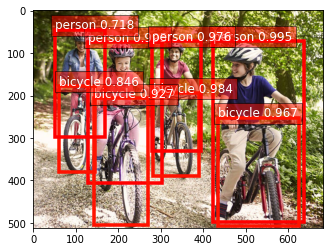

In [ ]:
from matplotlib import pyplot as plt
import gluoncv
from gluoncv import model_zoo, data, utils

net = model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)
im_fname = utils.download('https://www.ftfl.org/wp-content/uploads/2021/05/family-cycling.jpg')
x, orig_img = data.transforms.presets.yolo.load_test(im_fname, short=512)
print(f"Length of Class: {len(net.classes)}")
print(f"X shape: {x.shape}")
print(f"Orig_img shape: {orig_img.shape}")

class_IDs, scores, bounding_boxs = net(x)

print(f"Scores shape: {scores.shape}")
print(f"Bounding boxes shape: {bounding_boxs.shape}")

# keep = class_IDs[0].asnumpy().max(-1) > 1
ax = utils.viz.plot_bbox(orig_img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

# 2) Application - detr-resnet-50 by HuggingFace

https://medium.com/visionwizard/detr-b677c7016a47

In DETR, object detection problem is modeled as a direct set prediction problem. The approach don’t require hand crafted algorithms like non-maximum suppression procedure or anchor generation that explicitly encode our prior knowledge about the task. It makes the detection pipeline a simple end to end unified architecture.

The two novel components of the new framework, called DEtection TRansformer or DETR, are

*   a set-based global loss that forces unique predictions via bipartite matching
*   a transformer encoder-decoder architecture

<img src='https://miro.medium.com/max/967/1*ROEemTct0f47Y2kDlAAF4Q.png'>




In [ ]:
### demo inference code
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
from matplotlib.pyplot import imshow
torch.set_grad_enabled(False);

class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        # for now just random embedding
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):

        # inputs = (m, 3, 800, 1066)
        # propagate inputs through ResNet-50 up to avg-pool layer

        # (m, 64, 400, 533)
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)

        # (m, 64, 200, 267)
        x = self.backbone.maxpool(x)
        # (m, 256, 200, 267)
        x = self.backbone.layer1(x)
        # (m, 512, 100, 134)
        x = self.backbone.layer2(x)
        # (m, 1024, 50, 67)
        x = self.backbone.layer3(x)
        # (m, 2048, 25, 34)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        # (m, 256, 25, 34)
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]

        # (25, 34, 128) + (25, 34, 128) --> (25, 34, 256)
        # flatten --> (850, m, 256)
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        # pos encoding + CNN extractor output size = (850, m, 256)
        # decoder input = (100, m, 256) - to predict 100 classes / seq_length = 10
        # (m, 100, 256)
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
                            
        # finally project transformer outputs to class labels and bounding boxes
        # (m, 100, num_classes), (m, 100, 4)
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

Original Images Size:  torch.Size([1, 3, 800, 1066])
Keep Size:  torch.Size([100])
Class:  torch.Size([15, 91])
Pred Box:  torch.Size([15, 4])


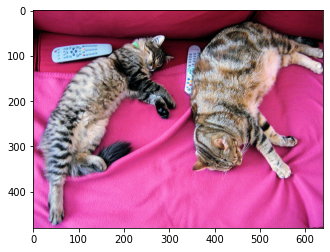

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
imshow(im)
img = transform(im).unsqueeze(0)
print('Original Images Size: ', img.size())

detr = DETRdemo(num_classes=91)
outputs = detr(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7
print('Keep Size: ', keep.size())

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

print('Class: ', probas[keep].size())
print('Pred Box: ', bboxes_scaled.size())

## 2.1 Loss Function

Two simple steps:

1.   Calculate the best match of predictions with respect to given ground truths using a graph technique with a cost function.(unique to DETR)
2.   define a loss to penalize the class and box predictions. (usual step)


A matching in a Bipartite Graph is a set of the edges chosen in such a way that no two edges share an endpoint. A maximum matching is a matching of maximum size (maximum number of edges).
In a maximum matching, if any edge is added to it, it is no longer a matching. There can be more than one maximum matching’s for a given Bipartite Graph.

<img src='https://miro.medium.com/max/840/0*WewQ33GyNqlxsXPa.png'>

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


logits torch.Size([1, 100, 92])
boundary box torch.Size([1, 100, 4])
proba torch.Size([100, 91])


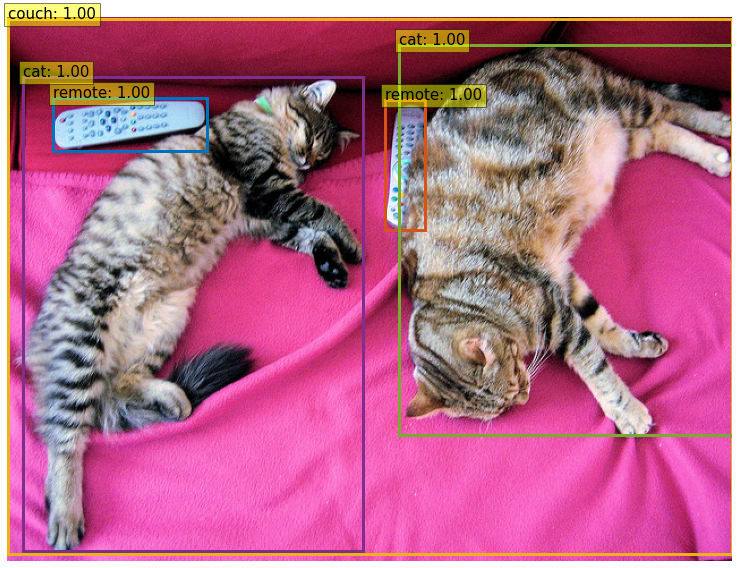

In [ ]:
### hugging face
import torch
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image
import requests
import matplotlib.pyplot as plt

def plot_results(pil_img, prob, boxes):
    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

print('logits', logits.size())
print('boundary box', bboxes.size())

# keep only predictions of queries with 0.9+ confidence (excluding no-object class)
probas = logits.softmax(-1)[0, :, : -1]
print('proba', probas.size())
keep = probas.max(-1).values > 0.9

# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1]).unsqueeze(0)
postprocessed_outputs = feature_extractor.post_process(outputs, target_sizes)
bboxes_scaled = postprocessed_outputs[0]['boxes'][keep]
plot_results(image, probas[keep], bboxes_scaled)

# 3) OWL-ViT


Detected a photo of a black dog with confidence 0.683 at location [65.7, 290.21, 182.51, 557.66]
Detected a photo of white dog with confidence 0.627 at location [170.75, 294.14, 273.72, 553.93]
Detected a photo of a black dog with confidence 0.655 at location [860.38, 268.04, 984.77, 564.79]
Detected a photo of white dog with confidence 0.724 at location [265.66, 285.79, 401.16, 551.97]
Detected a photo of white dog with confidence 0.771 at location [385.09, 252.14, 546.17, 568.5]
Detected a photo of white dog with confidence 0.644 at location [630.66, 254.95, 781.34, 579.34]
Detected a photo of white dog with confidence 0.699 at location [741.24, 267.81, 883.3, 564.72]
Detected a photo of white dog with confidence 0.611 at location [970.36, 328.26, 1120.66, 570.04]


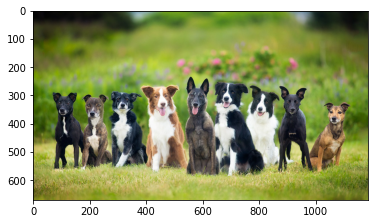

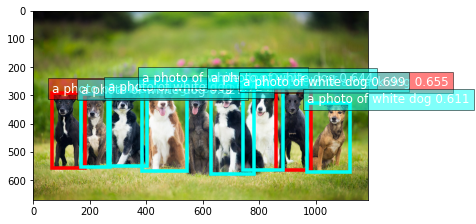

In [ ]:
import requests
from PIL import Image
import torch
from matplotlib.pyplot import imshow
import numpy as np
from gluoncv import utils

from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "https://cdn.fstoppers.com/styles/large-16-9/s3/lead/2017/07/nine-dogs-in-grassy-field.jpg"
image = Image.open(requests.get(url, stream=True).raw)
imshow(image)

texts = [["a photo of a black dog", "a photo of white dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

# Retrieve predictions for the first image for the corresponding text queries
i = 0  
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# print text
score_threshold = 0.6
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

### plot image
keep = scores > score_threshold
box = boxes[keep, :]
score = scores[keep]
label = labels[keep]

ax = utils.viz.plot_bbox(np.array(image), box, score.numpy(), np.array(label), class_names=texts[0])
plt.show()